# Program Header

In [43]:
import pandas as pd
import numpy as np
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
from header import *

In [44]:
data_root = initialize_data_root("AY")

In [45]:
import difflib
import jellyfish
import fuzzywuzzy
from fuzzywuzzy import process

# Table of contents
1. [Import](#Import)
2. [Create Tag Map](#CreateTagMap)
5. [Save](#Save)

## Import <a name="Import"></a>

In [46]:
raw_sec_data = pd.read_csv(data_root+'02-build/clean/2019q3/sec_data_long.csv')
raw_custom_tag_map = pd.read_csv(data_root+'02-build/clean/2019q3/custom_tag_map.csv')

In [47]:
sec_data = raw_sec_data.copy()

In [48]:
custom_tag_map = raw_custom_tag_map.rename({'raw_tag':'tag'}, axis = 'columns')

## Create Tag Map <a name="CreateTagMap"></a>

Let's define a tag's reach as the percent of companies seen that include the tag. The goal of creating a tag map and consolidating raw tags is to improve the average reach.

In [49]:
def get_tag_reach(tag):
    total = sec_data['tag'].isin([tag])
    return(sum(total)/len(sec_data.adsh.unique()))

In [50]:
all_tags = sec_data.tag.unique()

In [51]:
tag_view = sec_data.groupby('tag').nunique()['adsh'].sort_values()/len(sec_data.adsh.unique())

In [52]:
tag_view.describe()

count    18907.000000
mean         0.004235
std          0.035677
min          0.000173
25%          0.000173
50%          0.000173
75%          0.000346
max          0.986147
Name: adsh, dtype: float64

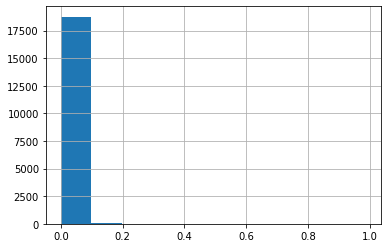

In [53]:
tag_view.hist()

Let's define a `common tag` as a tag with reach of at least 10%. We've already gone through all 149 common tags and consolidated them.

In [54]:
common_tags = tag_view.loc[tag_view >= 0.1]

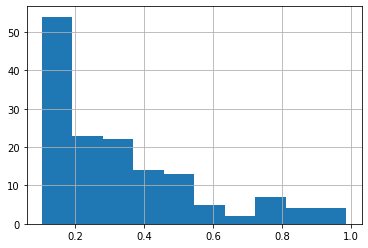

In [55]:
common_tags.hist()

Using the `common tags` list, let's find all fuzzy matches between the less common tags and the more common tags and store it in a dictionary:

In [56]:
def find_fuzzy_matches(parent_tag, children_tags):
    fuzzy_matches = process.extract(parent_tag, list(children_tags))
    matches = [i[0] for i in fuzzy_matches]
    return(matches)

In [57]:
less_common_tags = tag_view.loc[tag_view < 0.1].index
fuzzy_map = {}

In [58]:
for i in common_tags.index:
    matches = find_fuzzy_matches(i, less_common_tags)
    fuzzy_map[i] = matches

We'll convert these dictionary tag maps to a data-frame to easily use SQL-style joins.

In [59]:
fuzzy_map_df = pd.DataFrame(columns = ['clean_tag_pt1', 'tag'])
fuzzy_map_df

,clean_tag_pt1,tag


In [60]:
map_df_intermediate = pd.DataFrame(dict([(k,pd.Series(v)) for k,v in fuzzy_map.items()]))\
            .melt()\
            .dropna()\
            .rename({'variable':'tag', 'value':'raw_tag'}, axis = 'columns')\
            .drop_duplicates('raw_tag', keep = False)

In [61]:
map_df_intermediate.shape

(561, 2)

Now, we will use the custom tag map that consolidates the `common tags`. This was created using accounting and financial statement handbook resources and also required human judgment.

In [62]:
map_df = map_df_intermediate.merge(custom_tag_map, on = ['tag'])\
    .drop('tag', axis = 'columns')\
    .rename({'raw_tag':'tag'}, axis = 'columns')

In [63]:
map_df.head()

,tag,clean_tag
0,OperatingLeaseExpenseNetOfSubleaseIncome,SubleaseIncome
1,RentExpenseClosedStoresNetOfSubleaseIncome,SubleaseIncome
2,LeaseIncome,SubleaseIncome
3,SbaIncome,SubleaseIncome
4,OperatingLeaseLeaseIncomeTenantReimbursements,SubleaseIncome


We've mapped the less common tags to their proper clean tag counterpart. Now, we will add on the clean tags of the `common tags` to the map as well.

In [64]:
common_tags_cleaned = pd.DataFrame(common_tags.index).merge(custom_tag_map, on = ['tag'])

In [65]:
tag_map = pd.concat([map_df, common_tags_cleaned])

Let's see the results of our cleaning:

In [66]:
cleaned_sec = sec_data.merge(tag_map, on = ['tag'])
clean_tag_view = cleaned_sec.groupby('clean_tag').nunique()['adsh'].sort_values()/len(cleaned_sec.adsh.unique())

In [67]:
clean_tag_view.describe()

count    88.000000
mean      0.457356
std       0.267347
min       0.106357
25%       0.219037
50%       0.417287
75%       0.669409
max       0.986489
Name: adsh, dtype: float64

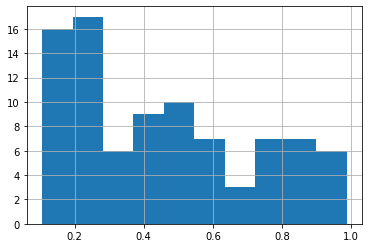

In [68]:
clean_tag_view.hist()

Much better!

So we see that our manual matching process has dramatically improved coverage among the common tags. Now, let's use fuzzywuzzy to classify less column tags as part of the common tags:

## Save <a name="Save"></a>
Save tag map to build/clean

In [69]:
# Save
tag_map.to_csv(data_root+'02-build/clean/2019q3/tag_map.csv', index = False)